# Practical exercise 2

*authors: Asan Agibetov, Georg Dorffner*

In this exercise you will learn how to use Convolutional Neural Networks (CNNs), and build a simple handwritten digit recognition system based on CNN. The acquired knowledge in this exercise will also be important for the next exercise, where you will build a CNN for the recognition of medical images.

## Package imports and global settings

In [9]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import itertools as it

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data preparation

We will be using the [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/) to demonstrate the application of convolutional neural networks. Pytorch has a related package - `torchvision`, which contains a set of convenience functions to prepare the commonly used datasets. In particular we will use `torchvision.datasets.MNIST` callable which will prepare MNIST data for us.

In [11]:
# Hyper Parameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

train_dataset = torch.load("./data/train.limited.pt")
test_dataset = torch.load("./data/test.limited.pt")

Due to the size and computational resource limitation imposed by Microsfot Azure Cloud platform for the free accounts, we will only use a fraction of available images both during training and testing. If you are preparing these exercises on your local machine, and have enough computational resources (any modern i5/i7 Intel CPU (or equivalent) machine), you could (and maybe you should) use the full dataset. 

*Contact your instructors for the full dataset.*

`torchvision.datasets.*` give us access to the raw (pixel intensities) and processed data (tensor representation). Having access to the tensor representation of images, we can now build *input pipeliens* for the CNNs which will load data in *batches*. We need the batch loading functionality for the *mini-batch stocastic optimization*. These pipelines are implemented in `torch.utils.data.DataLoader` class, which loads mini-batches (random samples) of our data in parallalel.

In [12]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

The dataset is split into *train* and *test* subsets, each element of either dataset contains one $28 \times 28$ image with labels, which we need to predict from image data.

torch.Size([1, 28, 28])
5


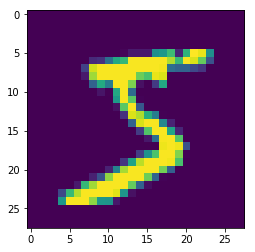

In [13]:
img, label = train_dataset[0]
print(img.shape)
print(label)
plt.imshow(img.squeeze().numpy())

torch.Size([1, 28, 28])
7


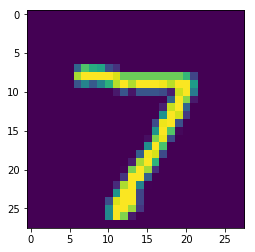

In [14]:
img, label = test_dataset[0]
print(img.shape)
print(label)
plt.imshow(img.squeeze().numpy())

Since we are limiting the number of samples of the original dataset (we pick a subset at random), we might have imbalanced classes, i.e., some classes might have much more samples than other. Below we simply count the number of images (samples) in each subset (train and test), make sure that the classes are "balanced", otherwise re-run the cells in the *Data preparation* section untill you get balanced classes.

In [50]:
from collections import Counter

tr_labels = [y for x, y in train_dataset]
te_labels = [y for x, y in test_dataset]
print(Counter(tr_labels))
print(Counter(te_labels))

Counter({7: 117, 1: 116, 4: 105, 9: 100, 2: 99, 0: 97, 6: 94, 3: 93, 5: 92, 8: 87})
Counter({1: 28, 4: 28, 7: 24, 9: 21, 5: 20, 6: 20, 0: 17, 2: 16, 3: 16, 8: 10})


## Convolutional Neural Network

We finally come to the central part of this exercise - the definition of a CNN. As you can see, a CNN is defined as a `pytorch` module consisting of *convolutional, maxpooling* and non-linear activation layers as you saw in lecture. In particular,

* `nn.Conv2D(n, m, kernel_size=k)` will take *n* 2d signals (images) and produce *m* 2d signals (filters) by convolving each of the *n* signals with a kernel (sliding window) of a size $k \times k$. Note that each of the *m* produced filters will have the dimension *N - k + 1*, where $N \times N$ is the dimension of the input 2d signal.
* `MaxPool2D(h)` will take the maximum value in the previous layer (usually on the produced filter images) in the $h \times h$ region. You should understand that the *maxpooling* layer will produce the output 2d signal of dimenions $\frac{M}{h} \times \frac{M}{h}$, where $M \times M$ - the size of the filter on which we perform *maxpooling*.
* `BatchNorm(m)` is a layer which is goind to normalize all values for the current batch, to avoid the problem of the vanishing gradients (i.e., it will make sure that the *learning* is not slowed down by the neurons with close to zero activations)

The convolutional pipeline of a CNN is succeded by the *classification* pipeline, consisting of *fully connected* layers (one or many). In particular, the fully connected layer will have to take as input the unwrapped 1d vector representation of the output of the convolution pipeline. You will have to manually determine the final dimensions of the fully connected layers. For instance, if the final layer in the convolution pipeline (usually a pooling layer) produced a 2d output of $\frac{M}{h} \times \frac{M}{h}$ dimensions, then the fully connected layer will map $\mathbb{R}^{\frac{M}{h} * \frac{M}{h}} \mapsto C$, where $C$ is the number of final categories (e.g., $C=2$ for binary classifications).

In [51]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            # nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # self.fc = nn.Linear(7*7*32, 10) 
        self.fc = nn.Linear(4*4*32, 10)
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 
    
# cnn = CNN()

### Exercise 2.1

Here, we start with images of $28 \times 28$ dimensions, and finally have a fully connected layer which maps vectors in $\mathbf{R}^{32*4*4}$ to $C=10$ (10 categories for 0-9 digits). Explain the derivation of the final size of the fully connected layer from the input images with the formulas provided for the convolutional and pooling layers above.

*Hint: the fully connected layer will receive $32$ images each of size $4 \times 4$*

**Comments:** <br /> 
**Following written-out derivation to make sure I understand it correctly:**

1. First Conv2D takes 1 image of dim $28 \times 28$ and returns 16 filters of (28-5+1=24)-> dimension $24 \times 24$.
2. First MaxPool2D takes 16 of these $28 \times 28$ arrays and returns 16 downsized arrays of dimension 24/2 i.e. $24 \times 24$.
3. Batchnorm leaves dimensions unchanged.
4. Start cycle again: second Conv2D takes the 16 filters of $12 \times 12$ dim, and now returns 32 filters of 12-5+1 -> i.e. dimension $8 \times 8$.
5. Second maxpool2d takes these 32 $12 \times 12$ arrays and down-samples to 8/2 -> i.e. of dimension $4 \times 4$.
6. Batchnorm leaves dimensions unchanged again...
7. Fully connected layer receives 32 arrays of size $4 \times 4$ and maps it to C=10.

The summary formula for end (side) dimension in this case would be <br /> 
**F_end = $(((I0 - k0 + 1)/M0) - k1 +1)/M1)$** <br /> 
where <br /> 
F_end = input dimension of fully connected layer <br /> 
I0 = original image dimension <br /> 
k0, k1 (..., ki) = kernel size of ith conv layer <br /> 
M0, M1 (..., Mi) = size of ith pooling layer

Also number of images N_end = output number of last conv layer

Recalculate: ((28 - 5 + 1)/2) - 5 +1 )/2 = 4, last conv layer output number is 32, hence total size is $4 \times 4 \times 32$ which matches result of written-out derivation.

### Exercise 2.2

What would be the size of the fully connected layer after a convolution pipeline consisting of

1. `nn.Conv2d(1, 16, kernel_size=7)` with $7 \times 7$ kernel
2. `nn.MaxPool2d(4)`
1. `nn.Conv2d(16, 32, kernel_size=5)` with $5 \times 5$ kernel
2. `nn.MaxPool2d(2)`

applied to images of dimensions $64 \times 64$?

*Hint: beware that some choice of dimensions may be incompatible, and may break the convolution pipeline*

**Comments:** <br /> 
**Using improvised formula from before:** <br /> 
F_end = ((64 - 7 + 1)/4) - 5 +1)/2 = 5.25 <br /> 
N_end = N(2nd Conv layer) = 32 <br /> 
Hence fully connected layer input size = F_end $\times$ F_end $\times$ N_end =  5.25$\times$5.25$\times$32 = **882** <br /> 

Needless to say, the decimal places should not be there - the first conv-layer and the first max pooling layer are mismatched: (64-7+1) -> 58, which is not divisible by 4.

This could be fixed any number of ways, e.g. by changing the first max pooling parameter to 2 and the second convolution kernel size to 6, which would give a $12 \times 12$ (integer-)dimensional fully connected layer.


### Training and evaluation

Below we train our CNN with stochastic mini-batch gradient descent. Note that we are only training for 10 epochs due to resource limitations, try to train for more epochs (try to get the loss error go to zero as much as possible) if you are doing these exercises on a local machine.

Epoch [1/10], Iter [5/10] Loss: 2.0078
Epoch [1/10], Iter [10/10] Loss: 1.6587
Epoch [2/10], Iter [5/10] Loss: 1.4705
Epoch [2/10], Iter [10/10] Loss: 1.2298
Epoch [3/10], Iter [5/10] Loss: 1.0636
Epoch [3/10], Iter [10/10] Loss: 0.8568
Epoch [4/10], Iter [5/10] Loss: 0.6929
Epoch [4/10], Iter [10/10] Loss: 0.6578
Epoch [5/10], Iter [5/10] Loss: 0.5206
Epoch [5/10], Iter [10/10] Loss: 0.4738
Epoch [6/10], Iter [5/10] Loss: 0.3926
Epoch [6/10], Iter [10/10] Loss: 0.3059
Epoch [7/10], Iter [5/10] Loss: 0.4077
Epoch [7/10], Iter [10/10] Loss: 0.2773
Epoch [8/10], Iter [5/10] Loss: 0.2948
Epoch [8/10], Iter [10/10] Loss: 0.2630
Epoch [9/10], Iter [5/10] Loss: 0.2761
Epoch [9/10], Iter [10/10] Loss: 0.1617
Epoch [10/10], Iter [5/10] Loss: 0.2137
Epoch [10/10], Iter [10/10] Loss: 0.1775
time elapsed: 8.91768503189087


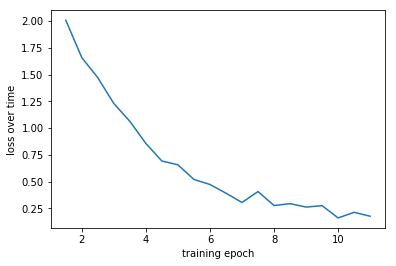

In [60]:
import time


def optimiser(test_net):
    start_time = time.time()
    epoch_data = []
    loss_data = []
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(test_net.parameters(), lr=learning_rate)

    # Train the Model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = test_net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (i+1) % 5 == 0:
                # for plotting, append epoch and loss data to timeseries:
                epoch_data.append(epoch+1+(i+1)/10.0) # epochs as 1, 1.5, 2.0 etc
                loss_data.append(loss.data[0])
                # print updates:
                print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

    print("time elapsed: {}".format(time.time()-start_time))
    plt.plot(epoch_data, loss_data)
    plt.ylabel('loss over time')
    plt.xlabel('training epoch')
    plt.show()
cnn = CNN()
optimiser(cnn)

Finally, we evaluate the *accuracy* of the CNN on the test dataset.

In [53]:
def tester(test_net):
    # Test the Model
    test_net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images)
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Test Accuracy of the model on the %d test images: %d %%' % (len(test_dataset), 100 * correct / total))

tester(cnn)

Test Accuracy of the model on the 200 test images: 96 %


### Exercise 2.3

Try to train *deeper* CNNs, make sure that compute the dimensions of the layers appropriately as you continuously downsample images (as a result of convolutions and maxpoling). Report differences with the provided CNN: convergence rate, i.e., time it takes to reduce loss error close to $0$ (within epsilon), contrast the plots of loss errors, compare test accuracy of the models.

**Comments:** <br /> 
**For the rest of the exercise, I decided to test 4 more CNNs:**
1. a 3-layer Conv-net with 1 fully connected linear output layer ("DeeperCNN")
2. a 4-layer Conv-net with 1 fully connected linear output layer ("EvenDeeperCNN")
3. the 3-layer Conv-net, this time with 3 fully connected linear output layers ("MoreFullDeepCNN")
3. the 4-layer Conv-net, this time with 3 fully connected linear output layers ("FullestDeepestCNN")

In [63]:
class DeeperCNN(CNN):
    # inherit 2-layer CNNs structure, modify second layer, add third conv-layer
    def __init__(self):
        super(DeeperCNN, self).__init__()
        # remove max-pooling from existing 2nd layer to reduce downsizing:
        self.layer2 = nn.Sequential(*list(self.layer2.children())[:-1])
        # add third conv-layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.fc = nn.Linear(6*6*64, 10)
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 

Epoch [1/10], Iter [5/10] Loss: 1.5734
Epoch [1/10], Iter [10/10] Loss: 0.8756
Epoch [4/10], Iter [10/10] Loss: 0.1963
Epoch [5/10], Iter [5/10] Loss: 0.1152
Epoch [5/10], Iter [10/10] Loss: 0.2296
Epoch [6/10], Iter [5/10] Loss: 0.1466
Epoch [6/10], Iter [10/10] Loss: 0.1285
Epoch [7/10], Iter [5/10] Loss: 0.1132
Epoch [7/10], Iter [10/10] Loss: 0.0452
Epoch [8/10], Iter [5/10] Loss: 0.0659
Epoch [8/10], Iter [10/10] Loss: 0.0693
Epoch [9/10], Iter [5/10] Loss: 0.0728
Epoch [9/10], Iter [10/10] Loss: 0.0532
Epoch [10/10], Iter [5/10] Loss: 0.0574
Epoch [10/10], Iter [10/10] Loss: 0.0278
time elapsed: 11.253701448440552


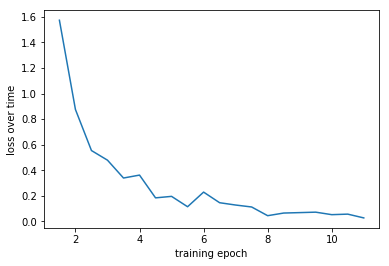

Test Accuracy of the model on the 200 test images: 97 %


In [64]:
deeper_cnn = DeeperCNN()

optimiser(deeper_cnn)
tester(deeper_cnn)

In [65]:
# 4-layer CNN module - define from scratch 
# layers change quite a bit (very granular) so inherit + mod makes less sense
class EvenDeeperCNN(nn.Module):
    def __init__(self):
        super(EvenDeeperCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU()) # 28-3+1 -> 26
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU()) # 26-3+1 -> 24 
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)) # 24-3+1 -> 22/2 -> 11 
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)) # 11-4+1 -> 8/2 -> 4
        self.fc = nn.Linear(4*4*128, 10)
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 

Epoch [1/10], Iter [5/10] Loss: 1.3514
Epoch [1/10], Iter [10/10] Loss: 0.7636
Epoch [2/10], Iter [5/10] Loss: 0.4990
Epoch [2/10], Iter [10/10] Loss: 0.3545
Epoch [3/10], Iter [5/10] Loss: 0.1789
Epoch [3/10], Iter [10/10] Loss: 0.1746
Epoch [4/10], Iter [5/10] Loss: 0.1340
Epoch [4/10], Iter [10/10] Loss: 0.1174
Epoch [5/10], Iter [5/10] Loss: 0.1072
Epoch [5/10], Iter [10/10] Loss: 0.0715
Epoch [6/10], Iter [5/10] Loss: 0.0600
Epoch [6/10], Iter [10/10] Loss: 0.0438
Epoch [7/10], Iter [5/10] Loss: 0.0481
Epoch [7/10], Iter [10/10] Loss: 0.0653
Epoch [8/10], Iter [5/10] Loss: 0.0226
Epoch [8/10], Iter [10/10] Loss: 0.0211
Epoch [9/10], Iter [5/10] Loss: 0.0259
Epoch [9/10], Iter [10/10] Loss: 0.0153
Epoch [10/10], Iter [5/10] Loss: 0.0144
Epoch [10/10], Iter [10/10] Loss: 0.0120
time elapsed: 61.63763236999512


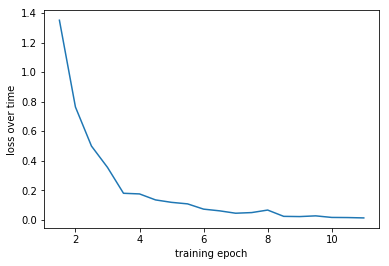

Test Accuracy of the model on the 200 test images: 98 %


In [66]:
even_deeper_cnn = EvenDeeperCNN()
optimiser(even_deeper_cnn)
tester(even_deeper_cnn)

In [69]:
class MoreFullDeepCNN(DeeperCNN):
    # keep 3-layer CNN structure
    # add additional fully connected layers at end for classification
    def __init__(self):
        super(MoreFullDeepCNN, self).__init__()
        # redefine fc layer to have more linear layers:
        self.fc = nn.Sequential(
            nn.Linear(6*6*64, 6*64),
            nn.ReLU(),
            nn.Linear(6*64, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        # no need to change forward-function definition as only changed fc

Epoch [1/10], Iter [5/10] Loss: 1.7553
Epoch [1/10], Iter [10/10] Loss: 0.9917
Epoch [2/10], Iter [5/10] Loss: 0.4996
Epoch [2/10], Iter [10/10] Loss: 0.5412
Epoch [3/10], Iter [5/10] Loss: 0.1546
Epoch [3/10], Iter [10/10] Loss: 0.1734
Epoch [4/10], Iter [5/10] Loss: 0.2538
Epoch [4/10], Iter [10/10] Loss: 0.0686
Epoch [5/10], Iter [5/10] Loss: 0.0786
Epoch [5/10], Iter [10/10] Loss: 0.1094
Epoch [6/10], Iter [5/10] Loss: 0.0712
Epoch [6/10], Iter [10/10] Loss: 0.0907
Epoch [7/10], Iter [5/10] Loss: 0.0362
Epoch [7/10], Iter [10/10] Loss: 0.0392
Epoch [8/10], Iter [5/10] Loss: 0.0428
Epoch [8/10], Iter [10/10] Loss: 0.0102
Epoch [9/10], Iter [5/10] Loss: 0.0074
Epoch [9/10], Iter [10/10] Loss: 0.0198
Epoch [10/10], Iter [5/10] Loss: 0.0110
Epoch [10/10], Iter [10/10] Loss: 0.0052
time elapsed: 16.782421827316284


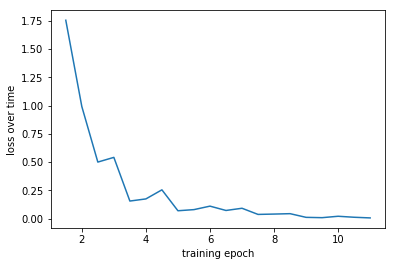

Test Accuracy of the model on the 200 test images: 97 %


In [70]:
more_full_deep_cnn = MoreFullDeepCNN()
optimiser(more_full_deep_cnn)
tester(more_full_deep_cnn)

In [73]:
class FullestDeepestCNN(EvenDeeperCNN):
    # keep 4-layer CNN
    # add additional fully connected layers at end for classification
    def __init__(self):
        super(FullestDeepestCNN, self).__init__()
        # redefine fc layer to have more linear layers:
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 4*128),
            nn.ReLU(),
            nn.Linear(4*128, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
        # again, no need to change forward-function definition as only changed fc

Epoch [1/10], Iter [5/10] Loss: 1.8467
Epoch [1/10], Iter [10/10] Loss: 0.8062
Epoch [2/10], Iter [5/10] Loss: 0.4044
Epoch [2/10], Iter [10/10] Loss: 0.1423
Epoch [3/10], Iter [5/10] Loss: 0.2487
Epoch [3/10], Iter [10/10] Loss: 0.1476
Epoch [4/10], Iter [5/10] Loss: 0.0940
Epoch [4/10], Iter [10/10] Loss: 0.1141
Epoch [5/10], Iter [5/10] Loss: 0.0549
Epoch [5/10], Iter [10/10] Loss: 0.0314
Epoch [6/10], Iter [5/10] Loss: 0.0538
Epoch [6/10], Iter [10/10] Loss: 0.0125
Epoch [7/10], Iter [5/10] Loss: 0.0111
Epoch [7/10], Iter [10/10] Loss: 0.0395
Epoch [8/10], Iter [5/10] Loss: 0.0044
Epoch [8/10], Iter [10/10] Loss: 0.0033
Epoch [9/10], Iter [5/10] Loss: 0.0030
Epoch [9/10], Iter [10/10] Loss: 0.0067
Epoch [10/10], Iter [5/10] Loss: 0.0038
Epoch [10/10], Iter [10/10] Loss: 0.0016
time elapsed: 63.8772988319397


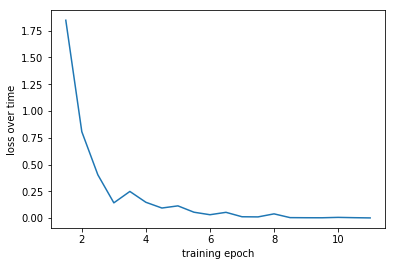

Test Accuracy of the model on the 200 test images: 97 %


In [74]:
fullest_deepest_cnn = FullestDeepestCNN()
optimiser(fullest_deepest_cnn)
tester(fullest_deepest_cnn)

**Comments:**
1. The extra convolutional layers in the 3- and 4-layer convnets brought a noticeable gain in classification accuracy (about 1 and 2 absolute percentage points, respectively) over the already well-performing 2-layer base convnet. My guess would be that higher than 98-99% accuracy could only be achieved with a lot of extra fine-tuning on this task, so reaching this level represents "convergence to the (achievable) optimum".
2. The time penalty of an extra convolutional layer is high - a roughly 50 second increase (or 5x multiplication!) from 11 to 60 seconds between the 3-layer and 4-layer convnet; Meanwhile, stacking an extra 3 linear layers as final classification filters only added 3 & 5 seconds, respectively, to the training time of the existing convnets. 
3. The simple 4-layer convnet (EvenDeeperCNN) without single FC layer at the end actually performed the best (98% class. accuracy), in fact better than its extension with extra linear layers. Perchance for very long training times the extra linear layers may bring some improvement but for further improvement I would focus on tuning the convolutional layers first (playing further with kernel size, investigating importance of max pooling size, etc. However, in the next exercise on medical imaging, I did see an improvement of accuracy by inclusion of extra linear layers, which is somewhat more intuitive due to higher complexity of features seen on that classification task.)